
## Importing Library and Loading Data

In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import torchvision

import random
import numpy as np
import torch.nn as nn
#from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import pickle

np.random.seed(4)

import torch 
import torch.nn as nn
from torch.optim.lr_scheduler import *
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import math
import os

In [2]:
train_transform = tt.Compose([
    tt.Resize((32,32)),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10('../data/', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10('../data/', train=False, download=True, transform=test_transform)

train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.80), int(len(train_dataset) * 0.2)])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_val_size = len(val_dataset)

classes = 10

num_clients = 5
rounds = 50
batch_size = 64
epochs_per_client = 1
learning_rate = 2e-2

In [4]:
total_train_size, total_test_size, total_val_size

(40000, 10000, 10000)

In [5]:
class CustomDataset(Dataset):
    def __init__(self,data,labels,transform=None):
        self.labels = labels
        self.data = data
        self.transform=transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.transform is not None:
            x = self.transform(x)            
        y = self.labels[idx]
        return x,y

In [6]:
data = []
target = []
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for batch in train_dataloader:
  x,y = batch
  for i in range(len(x)):
    data.append(x[i].numpy())
    target.append(int(y[i]))

In [7]:
len(data)

40000

In [8]:
data_list = {}
for i in range(classes):
  data_list[i]= []

for i in range(len(target)):
  data_list[target[i]].append(data[i])

In [9]:
def dataSplit(data_list , num_clients):
    client_data = [[[],[]] for i in range(num_clients)]
    classes = len(data_list.keys())
    
    data_size = 0
    for i in data_list.keys():
        data_size += len(data_list[i])
        
    data_size = int(data_size/num_clients)
    indx_lst = [0 for i in range(classes)]
    #print(data_size,indx_lst)
    
    for i in range(num_clients):
        #cl = np.unique(np.random.randint(0,classes,classes))
        cl = [i for i in range(classes)]
        frac = np.random.rand(len(cl)) 
        frac = frac / (np.sum(frac))
        frac = frac*data_size
        frac = frac.astype('int')
        
        for j in range(len(cl)):
            cls = cl[j]
            
            if(indx_lst[cls] + frac[j] < len(data_list[cls])):
                data = data_list[cls][indx_lst[cls] : indx_lst[cls]+frac[j]]
                indx_lst[cls] = indx_lst[cls]+frac[j]
            else:
                data = data_list[cls][indx_lst[cls] : len(data_list[cls])]
                indx_lst[cls] = (indx_lst[cls]+frac[j])%len(data_list[cls])
                data += data_list[cls][0 :indx_lst[cls]]
            target = [cls for i in range(frac[j])]
            
            client_data[i][0] += data
            client_data[i][1] += target
    return client_data
            
client_data = dataSplit(data_list , num_clients) 

In [10]:

for i in range(num_clients):
  print("classes present in clients:")
  print("client " + str(i),list(np.unique(client_data[i][1])) )

classes present in clients:
client 0 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
classes present in clients:
client 1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
classes present in clients:
client 2 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
classes present in clients:
client 3 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
classes present in clients:
client 4 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [11]:
target_count = [ [0 for i in range(num_clients)] for j in range(classes)]
client_labels = []
for i in range(len(client_data)):
  client_labels.append("Client:" + str(i))
  for j in range(len(client_data[i][1])):
    target_count[client_data[i][1][j]][i] +=1

print(target_count)

[[1337, 1251, 671, 842, 639], [756, 317, 1460, 1496, 1005], [1344, 1386, 1210, 832, 1236], [988, 1579, 1333, 172, 288], [964, 263, 266, 252, 605], [298, 959, 115, 870, 809], [1349, 14, 924, 837, 1106], [8, 620, 258, 1017, 408], [349, 70, 1129, 640, 893], [601, 1536, 628, 1037, 1006]]


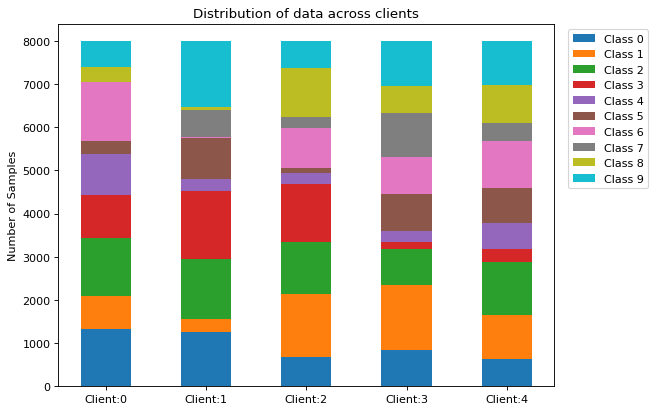

In [12]:
width = 0.5

plt.figure(figsize=(8, 6), dpi=80)

bottom_1 = np.array(target_count[0])
bottom_2 = bottom_1 + np.array(target_count[1])
bottom_3 = bottom_2 + np.array(target_count[2])
bottom_4 = bottom_3 + np.array(target_count[3])
bottom_5 = bottom_4 + np.array(target_count[4])
bottom_6 = bottom_5 + np.array(target_count[5])
bottom_7 = bottom_6 + np.array(target_count[6])
bottom_8 = bottom_7 + np.array(target_count[7])
bottom_9 = bottom_8 + np.array(target_count[8])

plt.bar(client_labels, target_count[0], width, label='Class 0')
plt.bar(client_labels, target_count[1], width, bottom=bottom_1,label='Class 1')
plt.bar(client_labels, target_count[2], width, bottom=bottom_2,label='Class 2')
plt.bar(client_labels, target_count[3], width, bottom=bottom_3,label='Class 3')
plt.bar(client_labels, target_count[4], width, bottom=bottom_4,label='Class 4')
plt.bar(client_labels, target_count[5], width, bottom=bottom_5,label='Class 5')
plt.bar(client_labels, target_count[6], width, bottom=bottom_6,label='Class 6')
plt.bar(client_labels, target_count[7], width, bottom=bottom_7,label='Class 7')
plt.bar(client_labels, target_count[8], width, bottom=bottom_8,label='Class 8')
plt.bar(client_labels, target_count[9], width, bottom=bottom_9,label='Class 9')
plt.ylabel('Number of Samples')
plt.title('Distribution of data across clients')
plt.legend()

plt.legend(bbox_to_anchor = (1.2, 1))

plt.show()

In [13]:

def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

## Models

In [14]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [15]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [16]:

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [17]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


In [18]:
class Client():   
    model = None 
    
    def __init__(self,client_id,dataset):
        self.model = ResNet18()
        self.model.to(get_device())
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id

    def apply_parameters(self, parameters_dict):
        state_dict = self.model.state_dict()
        for i in parameters_dict.keys():
          state_dict[i]= parameters_dict[i]
        self.model.load_state_dict(state_dict)

    def get_parameters(self):
        parameters_dict = dict()
        state_dict = self.model.state_dict()
        lst = list(state_dict.keys())

        for layer_name in lst:
          parameters_dict[layer_name] = state_dict[layer_name]
        return parameters_dict
             
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
          _, predictions = torch.max(outputs, dim=1)
          return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self.model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy )

    def fit(self, dataset, epochs, lr, batch_size=32, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.model.parameters(), lr)
        history = []

        for epoch in range(epochs):
          losses = []
          accs = []
          count = 0
          for batch in dataloader:
            loss, acc = self._process_batch(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accs.append(acc)

        
          avg_loss = torch.stack(losses).mean().item()
          avg_acc = torch.stack(accs).mean().item()
          history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=64):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
          for batch in dataloader:
            loss, acc = self._process_batch(batch)
            losses.append(loss)
            accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)
  
    
    def train(self,epochs):
        train_history = self.fit(self.dataset, epochs, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {} , Epochs = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4),epochs))

    def share_info(self,clients,fraction,curr_index,comm_index):
        temp = []
        temp.append(curr_index)
        for p in comm_index:
          temp.append(p)
        fraction = [fraction[t] for t in temp]
        fraction = np.array(fraction)
        fraction = fraction/np.sum(fraction)
        curr_parameters = self.get_parameters()
        new_parameters = dict()

        for para in curr_parameters.keys():
          new_parameters[para] = 0
        k = 0
        for cl in temp:
          client_parameters = clients[cl].get_parameters()
          for layer_name in client_parameters:
              new_parameters[layer_name] += fraction[k] * client_parameters[layer_name]
          k+=1
        self.apply_parameters(new_parameters)
        


    



In [19]:
client_datasets = [CustomDataset(client_data[i][0],client_data[i][1]) for i in range(num_clients)]
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [20]:
random_epochs = [[random.randint(1,epochs_per_client) for j in range(num_clients)] for i in range(rounds)]

## Training Loop

In [21]:
history_loss = []
history_acc = []
for i in range(rounds):
    
    print('Start Round {} .......................................'.format(i + 1))
    print()
    print()

    ##############    Deciding Communication Agreement    ######################
    #communication_agreement = [ random.sample(range(0,num_clients), 3)  for _ in range(num_clients)]
    communication_agreement = [ [p for p in range(num_clients)]  for _ in range(num_clients)]
    print("Communication Info : ")
    
    for c in range(num_clients):
      if c in communication_agreement[c]:
        communication_agreement[c].remove(c)
        
      print("client" ,c , end = " ")
      print('Communicates with : ',communication_agreement[c] )
    print()

    ############################################################################

    #################### Training Each Clients #################################
    print("Training started....")
    for clt in clients:
      clt.train(epochs_per_client)
  
    ############### Sharing of model parameters between clients ################
    print()

    '''Fractional importance of each clients using approach similar to fed avg in federated learning'''
    fraction = [client.get_dataset_size() / total_train_size for client in clients]
    for z in range(len(clients)):
      clients[z].share_info(clients,fraction,z,communication_agreement[z])
    print("Parameter Sharing Done......")
    print()
    ########################## Evaluating Clients ##############################
    print("Evaluating client after agregating shared parameters................")
    
    temp1 = []
    temp2 = []
    for clt in clients:
      train_loss, train_acc = clt.evaluate(train_dataset,batch_size)
      temp1.append(train_loss)
      temp2.append(train_acc)
    
      history_loss.append(temp1)
      history_acc.append(temp2)
    
      print('After round {}, {}: train_loss = {}, train_acc = {}\n'.format(i + 1, clt.client_id ,round(train_loss, 4), round(train_acc, 4)))
print() 
print() 
print("Training completed")

Start Round 1 .......................................


Communication Info : 
client 0 Communicates with :  [1, 2, 3, 4]
client 1 Communicates with :  [0, 2, 3, 4]
client 2 Communicates with :  [0, 1, 3, 4]
client 3 Communicates with :  [0, 1, 2, 4]
client 4 Communicates with :  [0, 1, 2, 3]

Training started....
client_0: Loss = 1.6355, Accuracy = 0.3837 , Epochs = 1
client_1: Loss = 1.5252, Accuracy = 0.4399 , Epochs = 1
client_2: Loss = 1.5786, Accuracy = 0.4279 , Epochs = 1
client_3: Loss = 1.646, Accuracy = 0.3974 , Epochs = 1
client_4: Loss = 1.6918, Accuracy = 0.3764 , Epochs = 1

Parameter Sharing Done......

Evaluating client after agregating shared parameters................
After round 1, client_0: train_loss = 2.411, train_acc = 0.1005

After round 1, client_1: train_loss = 2.3968, train_acc = 0.1063

After round 1, client_2: train_loss = 2.3688, train_acc = 0.1031

After round 1, client_3: train_loss = 2.3434, train_acc = 0.1185

After round 1, client_4: train_loss = 2.288

client_0: Loss = 0.5966, Accuracy = 0.7946 , Epochs = 1
client_1: Loss = 0.6141, Accuracy = 0.7765 , Epochs = 1
client_2: Loss = 0.5402, Accuracy = 0.8141 , Epochs = 1
client_3: Loss = 0.4421, Accuracy = 0.8475 , Epochs = 1
client_4: Loss = 0.359, Accuracy = 0.8843 , Epochs = 1

Parameter Sharing Done......

Evaluating client after agregating shared parameters................
After round 10, client_0: train_loss = 0.6174, train_acc = 0.7855

After round 10, client_1: train_loss = 0.6212, train_acc = 0.7847

After round 10, client_2: train_loss = 0.6382, train_acc = 0.7806

After round 10, client_3: train_loss = 0.64, train_acc = 0.7798

After round 10, client_4: train_loss = 0.6384, train_acc = 0.7812

Start Round 11 .......................................


Communication Info : 
client 0 Communicates with :  [1, 2, 3, 4]
client 1 Communicates with :  [0, 2, 3, 4]
client 2 Communicates with :  [0, 1, 3, 4]
client 3 Communicates with :  [0, 1, 2, 4]
client 4 Communicates with :  [0, 1, 

client_0: Loss = 0.3757, Accuracy = 0.8679 , Epochs = 1
client_1: Loss = 0.3363, Accuracy = 0.877 , Epochs = 1
client_2: Loss = 0.1079, Accuracy = 0.9671 , Epochs = 1
client_3: Loss = 0.0168, Accuracy = 0.9985 , Epochs = 1
client_4: Loss = 0.0096, Accuracy = 1.0 , Epochs = 1

Parameter Sharing Done......

Evaluating client after agregating shared parameters................
After round 18, client_0: train_loss = 0.4558, train_acc = 0.8594

After round 18, client_1: train_loss = 0.4655, train_acc = 0.8558

After round 18, client_2: train_loss = 0.4895, train_acc = 0.8519

After round 18, client_3: train_loss = 0.4684, train_acc = 0.8563

After round 18, client_4: train_loss = 0.4603, train_acc = 0.8596

Start Round 19 .......................................


Communication Info : 
client 0 Communicates with :  [1, 2, 3, 4]
client 1 Communicates with :  [0, 2, 3, 4]
client 2 Communicates with :  [0, 1, 3, 4]
client 3 Communicates with :  [0, 1, 2, 4]
client 4 Communicates with :  [0, 1, 2

client_0: Loss = 0.2293, Accuracy = 0.9229 , Epochs = 1
client_1: Loss = 0.026, Accuracy = 0.994 , Epochs = 1
client_2: Loss = 0.0075, Accuracy = 0.9994 , Epochs = 1
client_3: Loss = 0.004, Accuracy = 1.0 , Epochs = 1
client_4: Loss = 0.003, Accuracy = 0.9999 , Epochs = 1

Parameter Sharing Done......

Evaluating client after agregating shared parameters................
After round 26, client_0: train_loss = 0.4732, train_acc = 0.8671

After round 26, client_1: train_loss = 0.4707, train_acc = 0.8676

After round 26, client_2: train_loss = 0.4654, train_acc = 0.8694

After round 26, client_3: train_loss = 0.4623, train_acc = 0.8697

After round 26, client_4: train_loss = 0.4574, train_acc = 0.8712

Start Round 27 .......................................


Communication Info : 
client 0 Communicates with :  [1, 2, 3, 4]
client 1 Communicates with :  [0, 2, 3, 4]
client 2 Communicates with :  [0, 1, 3, 4]
client 3 Communicates with :  [0, 1, 2, 4]
client 4 Communicates with :  [0, 1, 2, 3

client_1: Loss = 0.0055, Accuracy = 0.9992 , Epochs = 1
client_2: Loss = 0.0024, Accuracy = 1.0 , Epochs = 1
client_3: Loss = 0.0017, Accuracy = 1.0 , Epochs = 1
client_4: Loss = 0.0011, Accuracy = 1.0 , Epochs = 1

Parameter Sharing Done......

Evaluating client after agregating shared parameters................
After round 34, client_0: train_loss = 0.4927, train_acc = 0.8687

After round 34, client_1: train_loss = 0.4868, train_acc = 0.871

After round 34, client_2: train_loss = 0.4829, train_acc = 0.8718

After round 34, client_3: train_loss = 0.4662, train_acc = 0.8746

After round 34, client_4: train_loss = 0.473, train_acc = 0.8737

Start Round 35 .......................................


Communication Info : 
client 0 Communicates with :  [1, 2, 3, 4]
client 1 Communicates with :  [0, 2, 3, 4]
client 2 Communicates with :  [0, 1, 3, 4]
client 3 Communicates with :  [0, 1, 2, 4]
client 4 Communicates with :  [0, 1, 2, 3]

Training started....
client_0: Loss = 0.2477, Accuracy = 

client_2: Loss = 0.0037, Accuracy = 0.9995 , Epochs = 1
client_3: Loss = 0.0011, Accuracy = 1.0 , Epochs = 1
client_4: Loss = 0.0007, Accuracy = 1.0 , Epochs = 1

Parameter Sharing Done......

Evaluating client after agregating shared parameters................
After round 42, client_0: train_loss = 0.5054, train_acc = 0.8713

After round 42, client_1: train_loss = 0.5104, train_acc = 0.8694

After round 42, client_2: train_loss = 0.5113, train_acc = 0.8697

After round 42, client_3: train_loss = 0.4927, train_acc = 0.8727

After round 42, client_4: train_loss = 0.4952, train_acc = 0.872

Start Round 43 .......................................


Communication Info : 
client 0 Communicates with :  [1, 2, 3, 4]
client 1 Communicates with :  [0, 2, 3, 4]
client 2 Communicates with :  [0, 1, 3, 4]
client 3 Communicates with :  [0, 1, 2, 4]
client 4 Communicates with :  [0, 1, 2, 3]

Training started....
client_0: Loss = 0.0024, Accuracy = 0.9999 , Epochs = 1
client_1: Loss = 0.0023, Accurac

client_3: Loss = 0.0009, Accuracy = 1.0 , Epochs = 1
client_4: Loss = 0.0006, Accuracy = 1.0 , Epochs = 1

Parameter Sharing Done......

Evaluating client after agregating shared parameters................
After round 50, client_0: train_loss = 0.4979, train_acc = 0.8736

After round 50, client_1: train_loss = 0.501, train_acc = 0.8723

After round 50, client_2: train_loss = 0.5005, train_acc = 0.8729

After round 50, client_3: train_loss = 0.4976, train_acc = 0.8731

After round 50, client_4: train_loss = 0.4924, train_acc = 0.8747



Training completed


## Plots

In [22]:
np.array(history_acc).dump(open('swarm_acc.npy', 'wb'))
np.array(history_loss).dump(open('swarm_loss.npy', 'wb'))

In [23]:
history = np.load(open('Fed_Avg_VGG16', 'rb'),allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'Fed_Avg_VGG16'

In [ ]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='b')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.show()

In [ ]:
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.title('Training History')
plt.show()